In [7]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,models,datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np, matplotlib.pyplot as plt,pandas as pd
from torchsummary import summary
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster
from glob import glob
from sklearn.model_selection import train_test_split
import os
import cv2
import matplotlib.ticker as mtick

In [8]:
%matplotlib inline

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6049, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6049 (delta 2), reused 1 (delta 1), pack-reused 6044 (from 2)
Receiving objects: 100% (6049/6049), 329.53 MiB | 12.85 MiB/s, done.
Resolving deltas: 100% (156/156), done.
Updating files: 100% (5805/5805), done.


In [31]:
train_dir = '/content/P1_Facial_Keypoints/data/training'

In [12]:
train_image_paths = glob(os.path.join(train_dir,'*.jpg'))

In [13]:
train_df= pd.read_csv('/content/P1_Facial_Keypoints/data/training_frames_keypoints.csv')

In [14]:
train_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0


In [55]:
class FacesDataset(Dataset):
  def __init__(self,df):
    super(FacesDataset).__init__()
    self.df = df
    self.normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
  def __len__(self):
    return len(self.df)

  def __getitem__(self,ix):
    img_path = '/content/P1_Facial_Keypoints/data/training/' + self.df.iloc[ix,0]
    img = cv2.imread(img_path) / 255
    kp = deepcopy(self.df.iloc[ix,1:].tolist())
    kp_x = (np.array(kp[0::2]) / img.shape[1]).tolist()
    kp_y = (np.array(kp[1::2]) / img.shape[0]).tolist()
    kp2 = kp_x + kp_y
    kp2 = torch.tensor(kp2)
    img = self.preprocess_input(img)
    return img,  kp2

  def preprocess_input(self,img):
    img = cv2.resize(img,(224,224))
    img = torch.tensor(img).permute(2,0,1)
    img = self.normalize(img).float()
    return img.to(device)

  def load_img(self, ix, folder='/content/P1_Facial_Keypoints/data/training/'):
    img_path = os.path.join(folder, self.df.iloc[ix, 0])
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.
    img = cv2.resize(img, (224, 224))
    return img



In [16]:
train, val = train_test_split(train_df,test_size = 0.2,random_state=101)

In [17]:
len(train),len(val)

(2769, 693)

In [18]:
train_dataset = FacesDataset(train.reset_index(drop=True))
val_dataset = FacesDataset(val.reset_index(drop=True))

In [19]:
train_loader = DataLoader(train_dataset,batch_size=32)
val_loader = DataLoader(val_dataset,batch_size=32)

In [20]:
def get_model():
  model = models.vgg16(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False
  model.avgpool = nn.Sequential(
      nn.Conv2d(512,512,3),
      nn.MaxPool2d(2),
      nn.Flatten()
  )

  model.classifier = nn.Sequential(
      nn.Linear(2048,512),
      nn.ReLU(),
      nn.Dropout(0.5),
      nn.Linear(512,136),
      nn.Sigmoid()

  )

  criterion = nn.L1Loss()
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
  return model.to(device),criterion, optimizer


In [21]:
model,criterion,optimizer = get_model()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 156MB/s]


In [22]:
def train_batch(img,kps,model,optimizer,criterion):
  model.train()
  optimizer.zero_grad()
  _kps = model(img.to(device))
  loss = criterion(_kps,kps.to(device))
  loss.backward()
  optimizer.step()
  return loss

In [23]:
def validate_batch(img,kps,model,criterion):
  model.eval()
  _kps = model(img.to(device))
  loss = criterion(_kps,kps.to(device))
  return _kps,loss

In [24]:
train_loss, validation_loss = [],[]
n_epochs = 50
for epoch in range(n_epochs):
  print(f'Epoch {epoch+1} / {n_epochs}')
  epoch_train_loss, epoch_val_loss = 0,0

  for ix, (img,kps) in enumerate(train_loader):

    loss = train_batch(img,kps,model,optimizer,criterion)
    epoch_train_loss += loss.item()

  epoch_train_loss /= len(train_loader)


  for ix,(img,kps) in enumerate(val_loader):

    kps, loss = validate_batch(img,kps,model,criterion)
    epoch_val_loss += loss.item()

  epoch_val_loss /= len(val_loader)

  train_loss.append(epoch_train_loss)
  validation_loss.append(epoch_val_loss)
  print(f"Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}")


Epoch 1 / 50
Train Loss: 0.05784334083912016, Validation Loss: 0.03353102183477445
Epoch 2 / 50
Train Loss: 0.04030297688026538, Validation Loss: 0.02684314853765748
Epoch 3 / 50
Train Loss: 0.03388901027026533, Validation Loss: 0.02492763940244913
Epoch 4 / 50
Train Loss: 0.03034771739066332, Validation Loss: 0.028872926719486713
Epoch 5 / 50
Train Loss: 0.0286925011367976, Validation Loss: 0.023146674121645363
Epoch 6 / 50
Train Loss: 0.027440192135072303, Validation Loss: 0.023641123859719795
Epoch 7 / 50
Train Loss: 0.0251748770817943, Validation Loss: 0.02169278467243368
Epoch 8 / 50
Train Loss: 0.025002878822985738, Validation Loss: 0.021200718950818886
Epoch 9 / 50
Train Loss: 0.025022247998878873, Validation Loss: 0.021803468296473675
Epoch 10 / 50
Train Loss: 0.024238804847687142, Validation Loss: 0.021781933832574974
Epoch 11 / 50
Train Loss: 0.02321624391894231, Validation Loss: 0.021289311349391937
Epoch 12 / 50
Train Loss: 0.022058485268518842, Validation Loss: 0.020465614

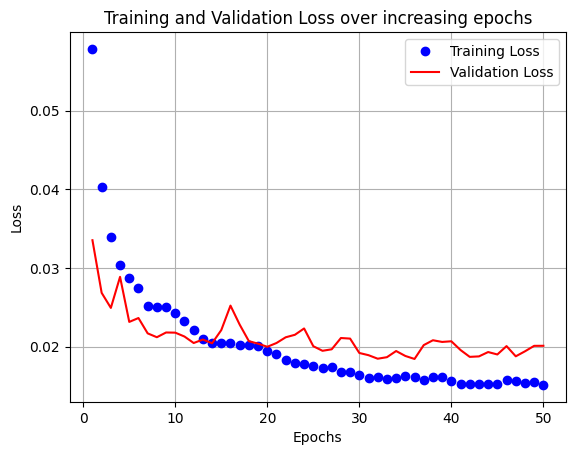

In [30]:
epochs = np.arange(50) + 1
plt.plot(epochs,train_loss,'bo',label="Training Loss")
plt.plot(epochs, validation_loss, 'r', label="Validation Loss")
plt.title("Training and Validation Loss over increasing epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid("off")
plt.show()


# Testing

In [64]:
test_df= pd.read_csv('/content/P1_Facial_Keypoints/data/test_frames_keypoints.csv')
test_dir = '/content/P1_Facial_Keypoints/data/test'

In [65]:
test_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,James_Wolfensohn_00.jpg,25.0,44.0,25.0,49.0,25.0,54.0,25.0,59.0,26.0,...,42.0,65.0,46.0,65.0,42.0,65.0,39.0,65.0,38.0,65.0
1,Valerie_Harper_30.jpg,55.0,62.0,52.0,72.0,52.0,83.0,55.0,90.0,55.0,...,78.0,104.0,88.0,106.0,78.0,106.0,75.0,104.0,70.0,104.0
2,Kristen_Breitweiser_11.jpg,60.0,88.0,60.0,98.0,63.0,109.0,65.0,116.0,68.0,...,96.0,114.0,106.0,117.0,96.0,117.0,94.0,117.0,89.0,117.0
3,Elizabeth_Dole_31.jpg,41.0,96.0,43.0,104.0,47.0,113.0,49.0,120.0,56.0,...,98.0,118.0,103.0,118.0,98.0,120.0,96.0,122.0,94.0,122.0
4,Kit_Bond_20.jpg,35.0,67.0,37.0,74.0,41.0,81.0,44.0,87.0,48.0,...,76.0,96.0,83.0,93.0,76.0,98.0,73.0,98.0,69.0,98.0


In [66]:
test_dataset = FacesDataset(test_df)
testloader = DataLoader(test_dataset,batch_size=32)

In [67]:
def denormalize_keypoints(pred,img_h = 224, img_w = 224):
  pred = pred.detach().cpu().numpy()
  x = pred[:,:68] * img_w
  y = pred[:,68:] * img_h
  kps = np.stack([x,y],axis=2)
  return kps


In [68]:
model.eval()
all_preds = []

with torch.no_grad():
  for img, _ in testloader:
    img = img.to(device)
    pred = model(img)
    kps = denormalize_keypoints(pred)
    all_preds.append(kps)


all_preds = np.concatenate(all_preds, axis = 0)

In [69]:
all_preds.shape

(770, 68, 2)

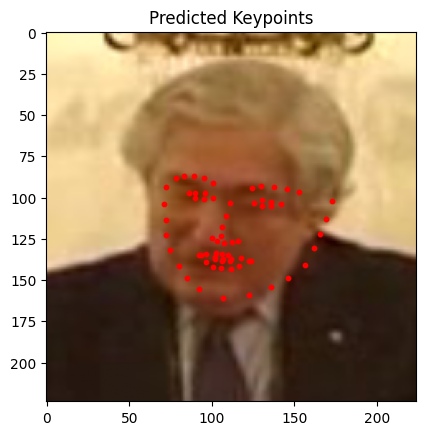

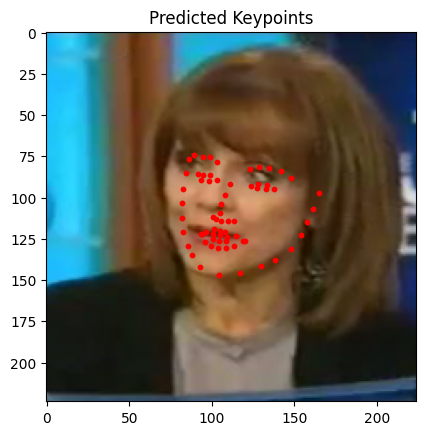

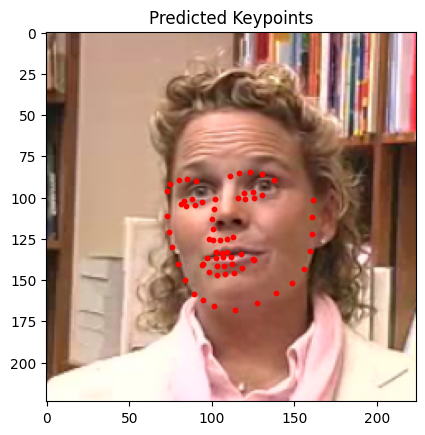

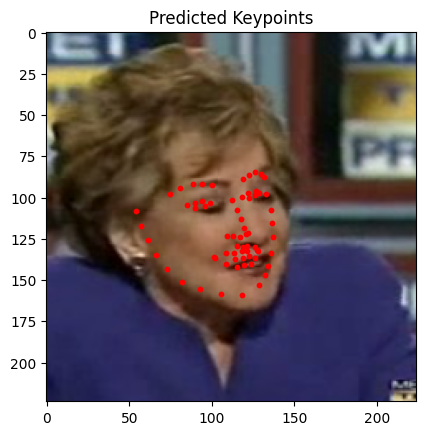

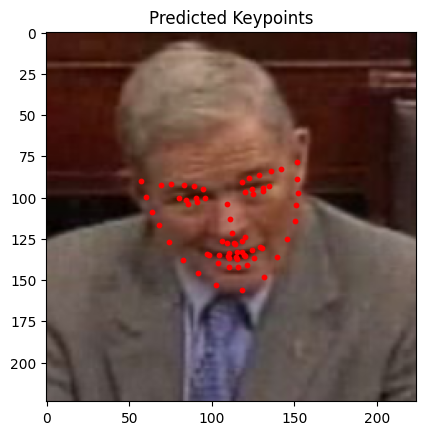

In [70]:
for i in range(5):
    img = test_dataset.load_img(i, folder=test_dir)
    pred_kps = all_preds[i]
    plt.imshow(img)
    plt.scatter(pred_kps[:,0], pred_kps[:,1], c='r', s=10)
    plt.title("Predicted Keypoints")
    plt.show()


In [71]:
torch.save(model.state_dict(), "facial_keypoints.pth")

In [80]:
from huggingface_hub import login, HfApi, upload_file

In [72]:
login()

In [76]:

api = HfApi()


In [79]:
repo_url = api.create_repo(repo_id='Facial_Keypoint_Detection',repo_type='space',space_sdk='gradio')
print(repo_url)

https://huggingface.co/spaces/faranbutt789/Facial_Keypoint_Detection


In [81]:
repo_id = "faranbutt789/Facial_Keypoint_Detection"
upload_file(
    path_or_fileobj = '/content/facial_keypoints.pth',
    path_in_repo = 'facial_keypoints.pth',
    repo_id=repo_id,
    repo_type="space"
)

facial_keypoints.pth:   0%|          | 0.00/72.8M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/spaces/faranbutt789/Facial_Keypoint_Detection/commit/d4dca38387fcf7313c93171b51c4359a318f9440', commit_message='Upload facial_keypoints.pth with huggingface_hub', commit_description='', oid='d4dca38387fcf7313c93171b51c4359a318f9440', pr_url=None, repo_url=RepoUrl('https://huggingface.co/spaces/faranbutt789/Facial_Keypoint_Detection', endpoint='https://huggingface.co', repo_type='space', repo_id='faranbutt789/Facial_Keypoint_Detection'), pr_revision=None, pr_num=None)